<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/2_Zero_order_methods/2_5_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 2: Zero order methods

# Random Search

In this Section we describe our first local optimization algorithms - *random local search* (sometimes called *simulated annealing*).  With this instance of the general local optimization framework discussed in the previous Section we seek out a descent direction at each step by examining a number of random directions stemming from our current point.  This manner of determining a descent direction, much like the global optimization scheme described in Section 5.2, scales terribly with the dimension of input and ultimately disqualifying random search for use with many modern machine learning / deep learning applications.  However this zero-order approach to local optimization is extremely useful as a simple example of the general framework introduced previously, allowing us to give simple yet concrete algorithmic example of universally present ideas like *descent directions*, various choices for the *steplength parameter*, and *issues of convergence*.

In [1]:
# import standard libs
import os

# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone library subdirectory
if not Path('chapter_2_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/2_Zero_order_methods/chapter_2_library
else:
    print('chapter_2_library already cloned!')

# clone images
if not Path('chapter_2_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/2_Zero_order_methods/chapter_2_images
else:
    print('chapter_2_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_2_library')
sys.path.append('./chapter_2_images') 

# import section helper
import section_2_5_helpers
plotter = section_2_5_helpers.Visualizer()

# image paths
image_path_1 = 'chapter_2_images/local.png'
image_path_2 = 'chapter_2_images/hypersphere_1d.png'
image_path_3 = 'chapter_2_images/hypersphere_2d.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_2_library already cloned!
chapter_2_images already cloned!


##  The random search algorithm

The defining characteristic of the *random local search* (or just *random search*) - as is the case with every local optimization method - is how the descent direction $\mathbf{d}^{k-1}$ at the $k^{th}$ local optimization update step

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} + \mathbf{d}^{k-1}.
\end{equation}

is determined.  With random search we do (perhaps) the laziest possible thing one could think to do in order to find a descent direction: we sample a given number of random directions stemming from $\mathbf{w}^{k-1}$, evaluate each candidate update point, and choose the one that gives us the smallest evaluation (so long as it is lower on the function than our current point).  In other words, we look locally around the current point in a fixed number of random directions for a point that has a lower evaluation, and if we find one we move to it.  

This idea illustrated figuratively in the picture below, where the function being minimized is the simple quadratic $g(w_1,w_2) = w_1^2 + w_2^2 + 2$, written more compactly as $g(\mathbf{w}) = \mathbf{w}^T \mathbf{w}^{\,} + 2$.  Here for visualization purposes we set the number of random directions sampled $P = 3$.  At each step only one of the three candidates produces a *descent direction* - drawn as a yellow arrow - while the other two are *ascent directions* drawn in blue.

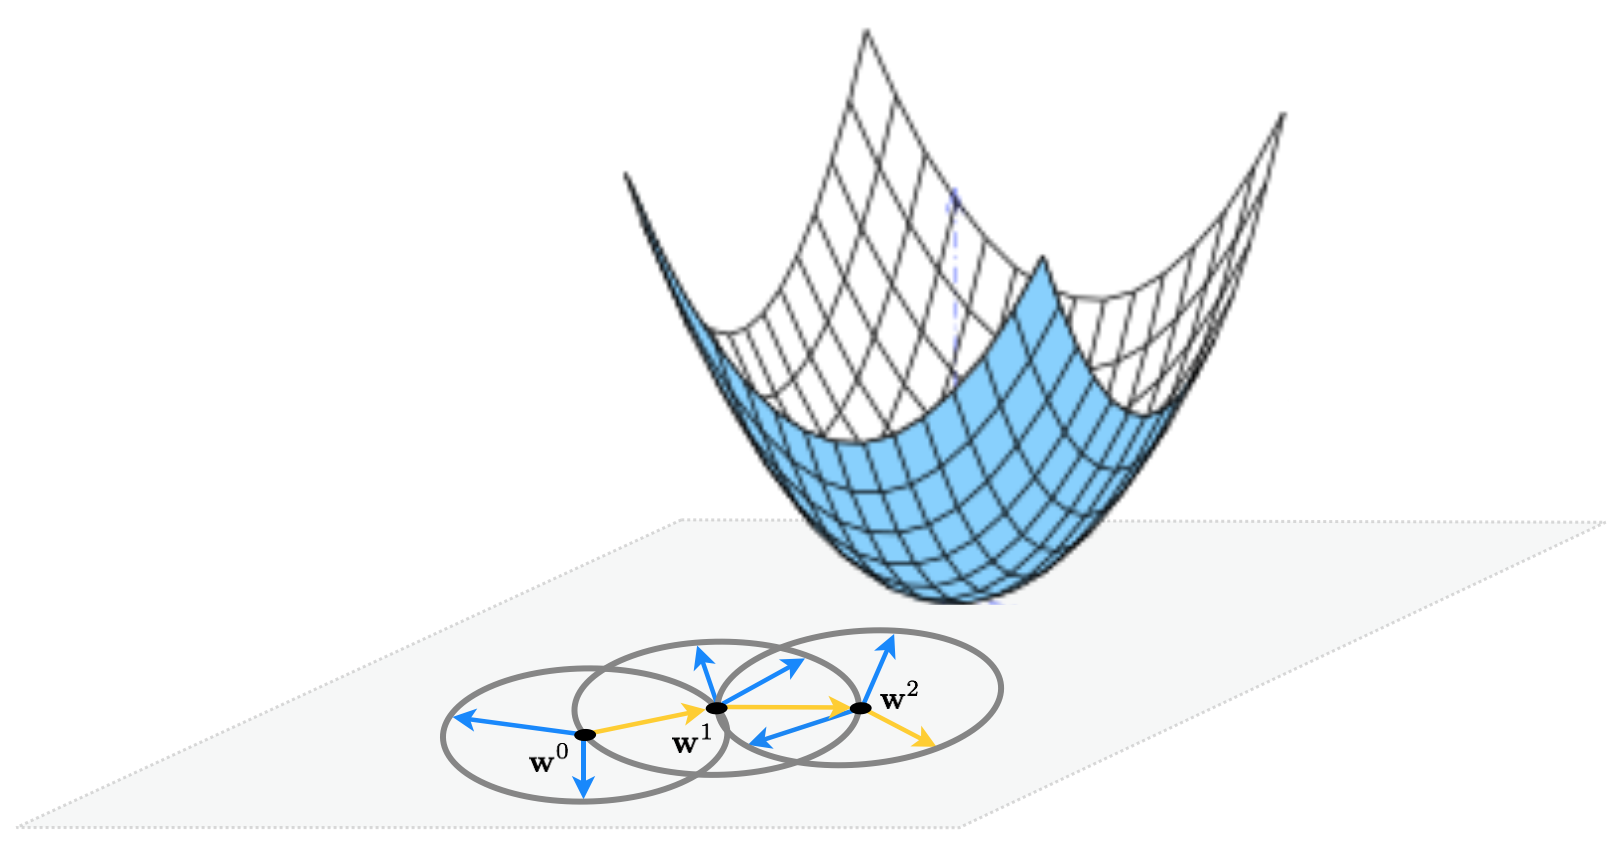

In [2]:
Image(image_path_1, width=800)

<figure>
<figcaption>   
<strong>Figure 1:</strong> <em> At each step the random search algorithm determines a descent direction by examining a number of random directions.  The direction leading to the new point with the smallest evaluation is chosen as the descent direction, and the process is started again.  Here we show three prototypical steps performed by random search, where three random directions are examined at each step.  In each step shown the descent direction chosen is colored yellow.
</em>  </figcaption> 
</figure>

To be more precise, at the $k^{th}$ step of this local method pick a number $P$ of random directions to try out.  Generating the $p^{th}$ random direction $\mathbf{d}^p$ stemming from the previous step $\mathbf{w}^{k-1}$ we have a candidate point to evaluate

\begin{equation}
\mathbf{w}_{\text{candidate}} = \mathbf{w}^{k-1} + \mathbf{d}^{p}
\end{equation}

After evaluating all $P$ candidate points we pick the one that gives us the *smallest* evaluation i.e., the one with the index given by the smallest evaluation 

\begin{equation}
s = \underset{p=1...P}{\text{argmin}}\,\,g\left(\mathbf{w}^{k-1} +  \mathbf{d}^p\right)
\end{equation}

Finally, if best point found has a smaller evaluation than the current point i.e., if  $g\left(\mathbf{w}^{k-1} + \mathbf{d}^s\right) < g\left(\mathbf{w}^{k-1}\right)$ then we move to the new point $\mathbf{w}^k = \mathbf{w}^{k-1} + \mathbf{d}^s$, otherwise we examine another batch of $P$ random directions and try again.

If we are to choose a set of directions at each step randomly, how shall we choose them?  One idea could be to use choose some distribution - e.g., a Gaussian - and (at each step) use samples from this distribution as our candidate directions.  The only issue with doing this is one of consistency: each of the candidate directions - if constructed in this way - would have different lengths.  Since we have no apriori reason for doing this at each step, to keep our random candidate directions consistent we can normalize them to have the same length e.g., length one.  Indeed this is how we illustrated the algorithm figuratively in the illustration above.  If we use directions of unit-length in our algorithm - i.e., where $\Vert \mathbf{d} \Vert_2 = 1$  always - this means that at each step of the algorithm we move a distance of length one since

\begin{equation}
\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \Vert \left(\mathbf{w}^{k-1} + \mathbf{d}\right) - \mathbf{w}^{k-1} \Vert_2  = \Vert \mathbf{d}  \Vert_2 = 1.
\end{equation}

From here we can adjust each step to have whatever length we desire by introducing a *steplength parameter* $\alpha$ into each step to completely control how far we travel with each step (as discussed in the previous Section).  This more general step looks like the following 

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha\mathbf{d}^{\,}
\end{equation}

The length of this step - using a unit-length directions - is now exactly equal to the steplength $\alpha$, as

\begin{equation}
\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \Vert \left(\mathbf{w}^{k-1} + \alpha\mathbf{d} \right) - \mathbf{w}^{k-1} \Vert_2  = \Vert \alpha \mathbf{d}  \Vert_2 = \alpha \Vert \mathbf{d}  \Vert_2 = \alpha
\end{equation}

Now at the $k^{th}$ step we try out $P$ unit-length random directions - but scaled by the steplength parameter so that the distance we travel is actually $\alpha$ - taking the one that provides the greatest decrease in function value.

In [3]:
# random search function
def random_search(g,alpha_choice,max_its,w,num_samples):
    # run random search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of random unit directions
        directions = np.random.randn(num_samples,np.size(w))
        norms = np.sqrt(np.sum(directions*directions,axis = 1))[:,np.newaxis]
        directions = directions/norms   
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

#### <span style="color:#a50e3e;">Example 1. </span>  Random search applied to minimize a simple quadratic

In the next Python cell we run random local search for 4 steps with $\alpha = 1$ for all steps, at each step searching for $P = 1000$ random directions to minimize the simple quadratic

\begin{equation}
g(w_0,w_1) = w_0^2 + w_1^2 + 2
\end{equation}

The output of the cell shows the function in three-dimensions on the left, along with the set of steps produced by the algorithm colored from green - at the start of the run where we initialize at $\mathbf{w}^0 = \begin{bmatrix}3 \\ 4\end{bmatrix}$ - to red when the algorithm halts.  Directed arrows illustrate each descent direction chosen, connecting each step to its predecessor, and are shown in the input space to help illustrate the total path the algorithm takes.  In the right panel is the same picture, only viewed from directly above.  Here contours of the function are drawn, with smaller values on the function corresponding to contours of decreasing radius and colored lighter blue.  

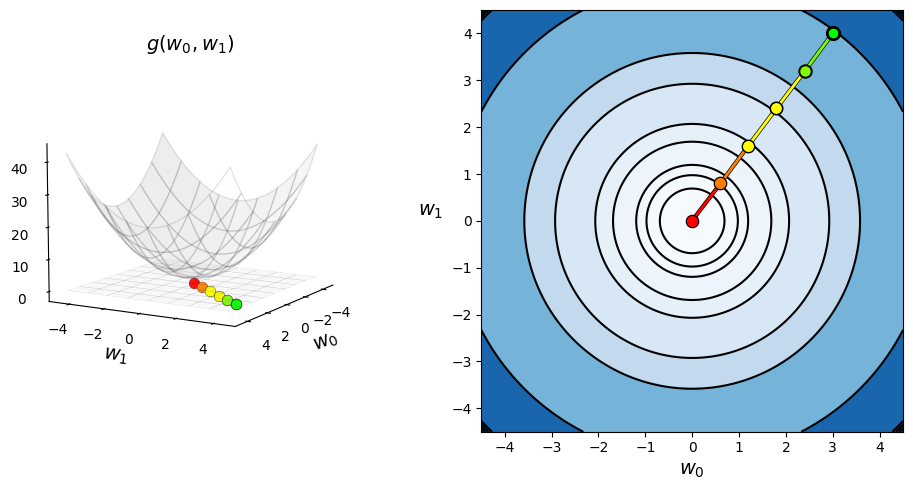

In [4]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history,cost_history = random_search(g,alpha_choice,max_its,w,num_samples)

# show run in both three-dimensions and just the input space via the contour plot
plotter.two_input_surface_contour_plot(g,weight_history,view = [10,30],xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)

---

Notice that if the dimension of the input $N$ is greater than $2$ we cannot make a plot like the ones above to tell how well a particular run of random search performed - or any local optimization method for that matter.  A more general way to view the steps from the particular run of any local method regardless of input dimension - which of course we do in order to examine the quality of its solution, and for the proper setting of the steplength parameter $\alpha$ as well as for general debugging purposes -  is to plot the corresponding sequence of function evaluations.  That is if the returned history of weights from a local method run is $\left\{\mathbf{w}^{k}\right\}_{k=0}^K$ we plot corresponding function evaluations $\left\{g\left(\mathbf{w}^{k}\right)\right\}_{k=0}^K$ as pairs $\left(k\,, g\left(\mathbf{w}^k\right)\right)$ as we demonstrate below.  This allows us to tell - regardless of the input dimension $N$ - how the algorithm performed.  This is why our random search algorithm returns the variable ``cost_history``, which contains this sequence of function evaluations.

This visualization is called a *cost function history plot* - since mathematical functions are often referred to as *cost* functions in machine learning / deep learning - and are employed virtually whenever a local algorithm is used in practice.  We produce a cost function history plot using the output of the previous example below.  Notice an additional benefit of this visualization - we can more easily tell the exact value of each function evaluation during the previous run of random search.

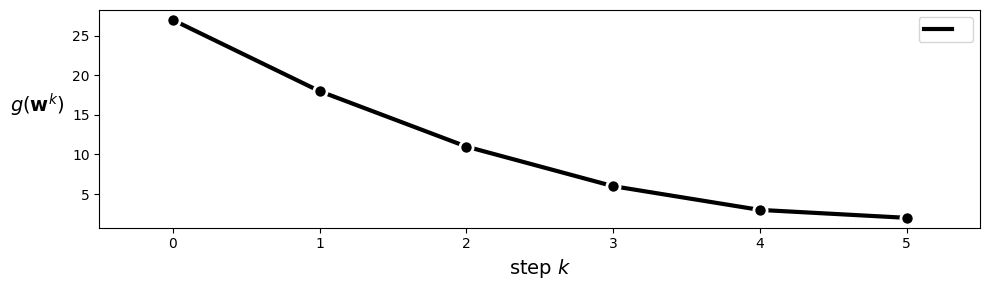

In [5]:
# plot the cost function history for a given run
plotter.plot_cost_histories([cost_history],start = 0,points = True)

---

#### <span style="color:#a50e3e;">Example 2. </span>  Minimizing a function with many local minima using random search

In this example we show what one may need to do in order to find the global minimum of a function using (normalized) random local search.  For visualization purposes we use the single-input function

\begin{equation}
g(w) = \text{sin}(3w) + 0.1w^2
\end{equation}

we initialize two runs - at $w^0 = 4.5$ and $w^0 = -1.5$.  For both runs we use a steplength of $\alpha = 0.1$ fixed for all 10 iterations.  As can be seen by the result depending on where we initialize we may end up near a local or global minimum - here resulting from the first and second initialization respectively.  Here we illustrate the steps of each run as circles along the input axis with corresponding evaluations on the function itself as a similarly colored 'x'.  The steps of each run are colored green near the start of the run to red when a run halts.

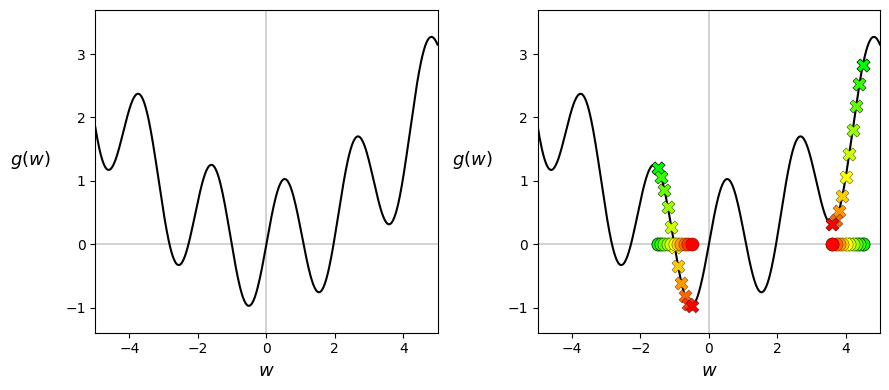

In [6]:
# define function
g = lambda w: np.sin(3*w) + 0.1*w**2

# run random search algorithm 
alpha_choice = 0.1; w = 4.5; num_samples = 10; max_its = 10;
weight_history_1,cost_history_1 = random_search(g,alpha_choice,max_its,w,num_samples)

alpha_choice = 0.1; w = -1.5; num_samples = 10; max_its = 10;
weight_history_2,cost_history_2 = random_search(g,alpha_choice,max_its,w,num_samples)

# make static plot showcasing each step of this run
plotter.single_input_plot(g,[weight_history_1,weight_history_2],[cost_history_1,cost_history_2],wmin = -5,wmax = 5)

##  Exploring fundamental steplength rules

In the examples of the previous Subsection we steplength parameter $\alpha$ set fixed for all steps of each run.  This choice - to take one value for $\alpha$ and use if to each and every step of the algorithm - is called a fixed *steplength rule*.  This is a very common choice of steplength rule for local optimization methods in general, but one can also imagine changing the value of $\alpha$ from step-to-step in a single run of a local algorithm.  A rule that adjusts the value of $\alpha$ from step-to-step is often referred to as an *adjustable* steplength rule, of which there are many in use.  

In this Section we explore a set of examples that further exemplifies the importance of the fixed steplength rule, as well as perhaps the most common adjustable steplength rule used when applying local optimization in machine learning / deep learning: the so-called *diminishing* steplength rule.

#### <span style="color:#a50e3e;">Example 3. </span>  Unit length steps fail to converge to global minimum

Here we re-run the random local search algorithm using the same simple quadratic and algorithm settings as described in Example 1 (where in particular we used a fixed steplength rule setting $\alpha = 1$ for all steps).  However now we initialize at the point $\mathbf{w}^0 = \begin{bmatrix} 1.5 \\ 2 \end{bmatrix}$ which - as can see in the printout generated by the next Python cell - prevents the algorithm from reaching the function's global minimum.  Note here we do not color the contour plot so that the radius of choices provided by the particular fixed steplength $\alpha = 1$ can be made visible on the contour plot itself.

Here the algorithm  - while having reached a low point of the function has not reached the global minimum located at the origin $\begin{bmatrix}0 \\ 0 \end{bmatrix}$ (horizontal and vertical axes have been drawn in dashed black in the right panel to highlight this point).  The algorithm stopped after taking 4 steps, at the point colored red.  We visualize this in the right panel by drawing the contour of the quadratic on which the final point lies in dashed red, as well as the unit circle centered at the final point in blue from which directions are sampled in search of a descent direction there.  Notice how every point on the blue unit circle - representing possible direction of length one stemming from the final step - lies on a contour of the quadratic that is greater than or equal to the one on which the final point lies.  Hence very possible direction provides ascent, not descent, and the algorithm halts.  In contrast to a descent direction such directions, which increase instead of decrease the function, are called *ascent directions*.

The problem here is that each direction we take must have length one since we have set $\alpha = 1$ for all steps - thus the length of each step must be length one as well.  If we could take *shorter* steps - i.e., steps on a smaller radius than the blue circle shown in the right panel above - we could in fact descend onto lower contours of the quadratic, and get closer to the global minimum.  This of course can be accomplished by using a smaller value for the steplength parameter $\alpha$.

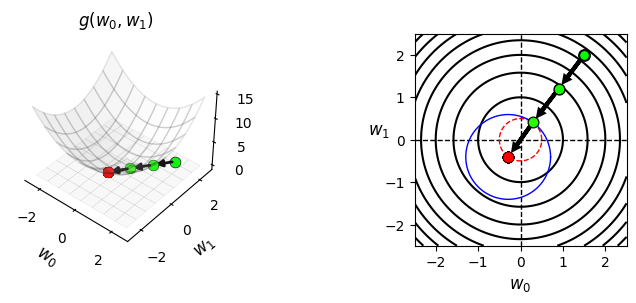

In [7]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 1; w = np.array([1.5,2]); num_samples = 1000; max_its = 30;
weight_history_1,cost_history_1 = random_search(g,alpha_choice,max_its,w,num_samples)

# animate 2d slope visualizer
view = [40,-50]
section_2_5_helpers.visualize3d(g,weight_history_1,cost_history_1,view = view,wmax=max(w[0],w[1]),plot_final = True,axes = True)

We can visualize how the final 25 steps of this sort of run fail to descend by plotting the corresponding cost function history, which we do below.  This common visualization tool really helps us to see how - after the first few steps - random search with these parameter settings fails to descend.

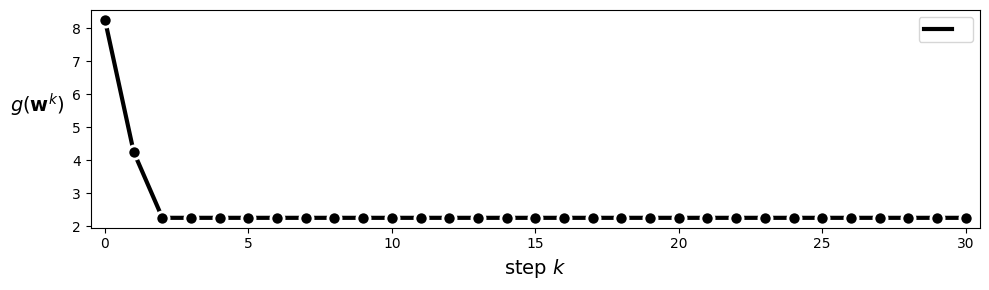

In [8]:
# plot the cost function history for a given run
plotter.plot_cost_histories([cost_history_1],start = 0,points = True)

Setting the steplength parameter $\alpha$ smaller we can look again make another run mirroring the one performed above, with much better results.  Below we make the same run as above except now we set $\alpha = 0.1$ for all steps.  Running the algorithm now we can see that it converges to a point much closer to the global minimum of the function at $\mathbf{w} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.

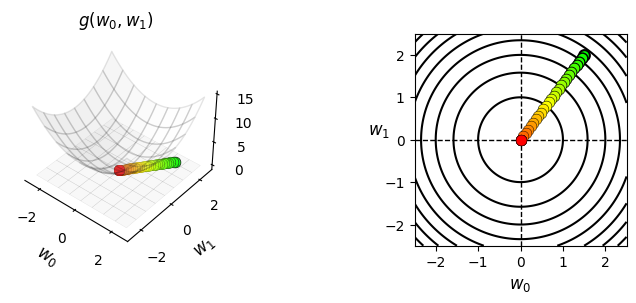

In [9]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 0.1; w = np.array([1.5,2]); num_samples = 1000; max_its = 30;
weight_history_2,cost_history_2 = random_search(g,alpha_choice,max_its,w,num_samples)

# animate 2d slope visualizer
view = [40,-50]
section_2_5_helpers.visualize3d(g,weight_history_2,cost_history_2,view = view,wmax=max(w[0],w[1]),plot_final = False,axes = True)

Notice however that we need to be careful in choosing the steplength value with this simple quadratic, and by extension any general function.  If - for example - we run the same experiment again but cut the steplength down to $\alpha = 0.01$ we do not reach a point anywher near the global minimum, as we show by performing the same run but setting $\alpha$ to this value in the next Python cell.  

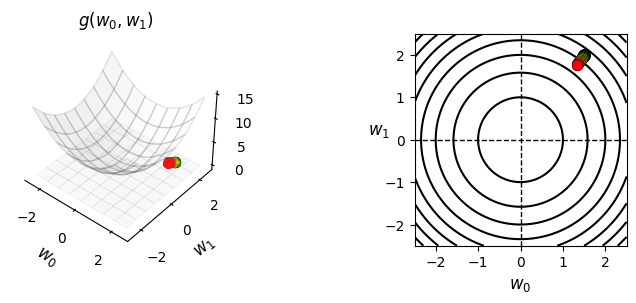

In [10]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 0.01; w = np.array([1.5,2]); num_samples = 1000; max_its = 30;
weight_history_3,cost_history_3 = random_search(g,alpha_choice,max_its,w,num_samples)

# animate 2d slope visualizer
view = [40,-50]
section_2_5_helpers.visualize3d(g,weight_history_3,cost_history_3,view = view,wmax=max(w[0],w[1]),plot_final = False,axes = True)

Thus in general the combination of steplength and maximum number of iterations are best chosen together.  The trade-off here is simple: a small stepsize combined with a large number of steps can guarantee convergence to towards a local minimum, but can be very computationally expensive.  Conversely a large steplength and small number of maximum iterations can - as we saw in Example 6 - be cheaper but less effective at finding small evaluation points.

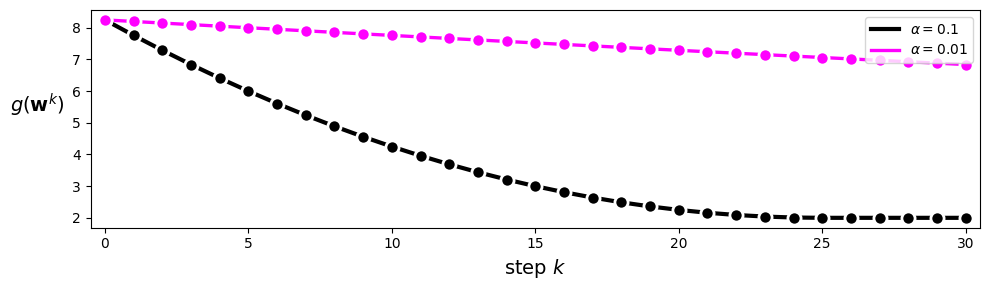

In [11]:
# plot the cost function history for a given run
plotter.plot_cost_histories([cost_history_2,cost_history_3],start = 0,points = True,labels = [r'$\alpha = 0.1$',r'$\alpha = 0.01$'])

---

Another choice we have in choosing steplengths is to change its value at each step.  For more advanced local search algorithms there are a host of ways of doing this, but with a simple method we discuss here there is really only one appropriate general scheme: to diminish the size of the steplength at each step.  This is a safe choice of steplength because it ensures that the algorithm can get into any 'small nooks and crannies' where a function's minima may lie.  This is often referred to as a *diminishing steplength rule*.

A common way of producing a diminishing steplength is tto set $\alpha = \frac{1}{k}$ at the $k^{th}$ step of the process.  This gives us the benefit of shrinking the distance between subsequent steps as we progress on a run since with this choice of steplength and a unit-length descent direction we have that

\begin{equation}
\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \Vert \left(\mathbf{w}^{k-1} + \alpha\mathbf{d}\right) - \mathbf{w}^{k-1} \Vert_2  = \Vert \alpha \mathbf{d}  \Vert_2 = \alpha \Vert \mathbf{d}  \Vert_2 = \alpha = \frac{1}{k}.
\end{equation}

However at the same time we can see that if we sum up the total distance the algorithm travels in $K$ steps (provided we indeed move at each step) we can then consequentially compute

\begin{equation}
\sum_{k=1}^{K} \Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \sum_{k=1}^{K}\frac{1}{k}
\end{equation}

The beauty of this choice of stepsize is that

- clearly the stepsize decreases to zero as $k$ increases i.e., $\alpha = \frac{1}{k} \longrightarrow 0$


- the total distance traveled by the algorithm goes to infinity as $k$ increases i.e., $\sum_{k=1}^{K}\frac{1}{k} \longrightarrow \infty$

The latter condition follows from the fact that $\sum_{k=1}^{\infty}\frac{1}{k} = \infty$ is the class *[harmonic series](https://en.wikipedia.org/wiki/Harmonic_series_(mathematics))*.  

So in theory this means that an algorithm employing this sort of diminishing steplength rule can move around an infinite distance in search of a minimum all the while taking smaller and smaller steps, which allows it to work into any 'small nooks and crannies' a function might have where any minimum lie.

##  The curse of dimensionality and random search

As with the global optimization approach discussed in the previous Section, the curse of dimensionality also poses a major obstacle to random local search as the dimension of a function's input increases. We illustrate this using a sequence of simple quadratic functions (where we will gradually increase the input dimension $N$)

\begin{equation}
g\left(\mathbf{w}\right)=\mathbf{w}^{T}\mathbf{w}+2
\end{equation}

starting at the point 

\begin{equation}
\mathbf{w}^{0}=\left[\begin{array}{c}
1\\
0\\
0\\
\vdots\\
0
\end{array}\right]_{ N\times1}
\end{equation}

When $N=1$, this reduces to finding a descent direction at random for the function $g(w)=w^2$ starting at $w^0=1$, as shown in the figure below. 

Here, starting at $w^0=1$, there are only 2 unit directions we can move in: (i) the negative direction toward the origin shown in yellow, which is a descent direction (as it takes us to the minimum of our quadratic function), or (ii) away from the origin shown in blue, which is indeed an ascent direction (as the function evaluation increases at its endpoint). So in this case, if we decide to choose our direction randomly we will have a $\frac{1}{2}=50\%$ descent probability. Not too bad!  

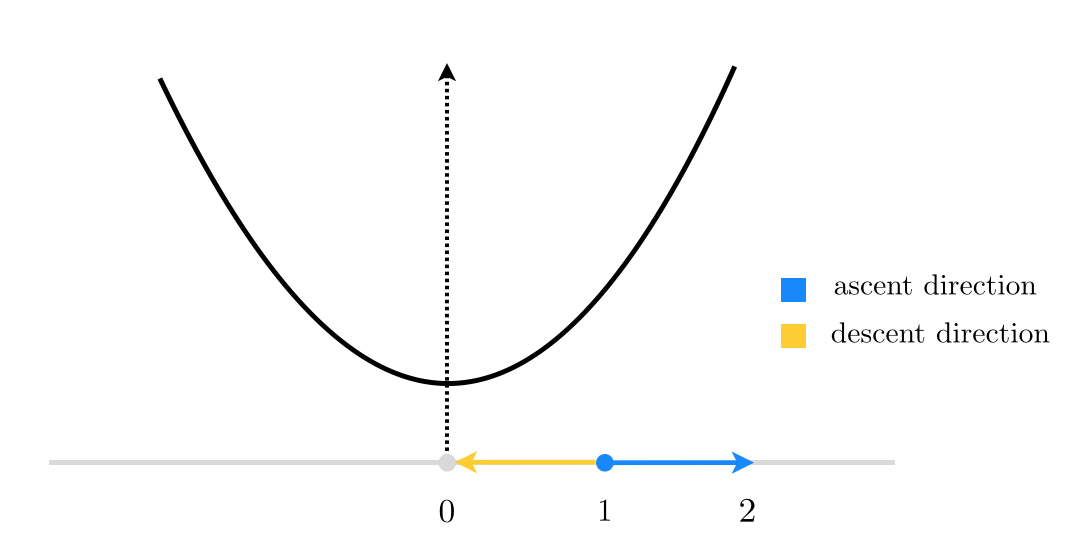

In [12]:
Image(image_path_2, width=800)

Let's see what happens when $N=2$. As you can see in the figure below, starting at $\mathbf{w}^{0}=\left[\begin{array}{cc}
1 \\ 0\end{array}\right]$ (shown by a blue circle) we now have infinitely many unit directions to choose from, where only a fraction of them whose endpoint lie inside the unit circle (centered at origin) are descent directions. Therefore if we were to choose a unit direction randomly, the descent probability would be calculated as the length of the yellow arc in the figure divided by the entire length of the unit circle centered at $\mathbf{w}^{0}$.

\begin{equation}
\text{descent probability}=\frac{\text{length of yellow arc}}{\text{length of unit circle}}
\end{equation}

For more clarity, the two-dimensional input space is re-drawn from above in the right panel of the figure below.     

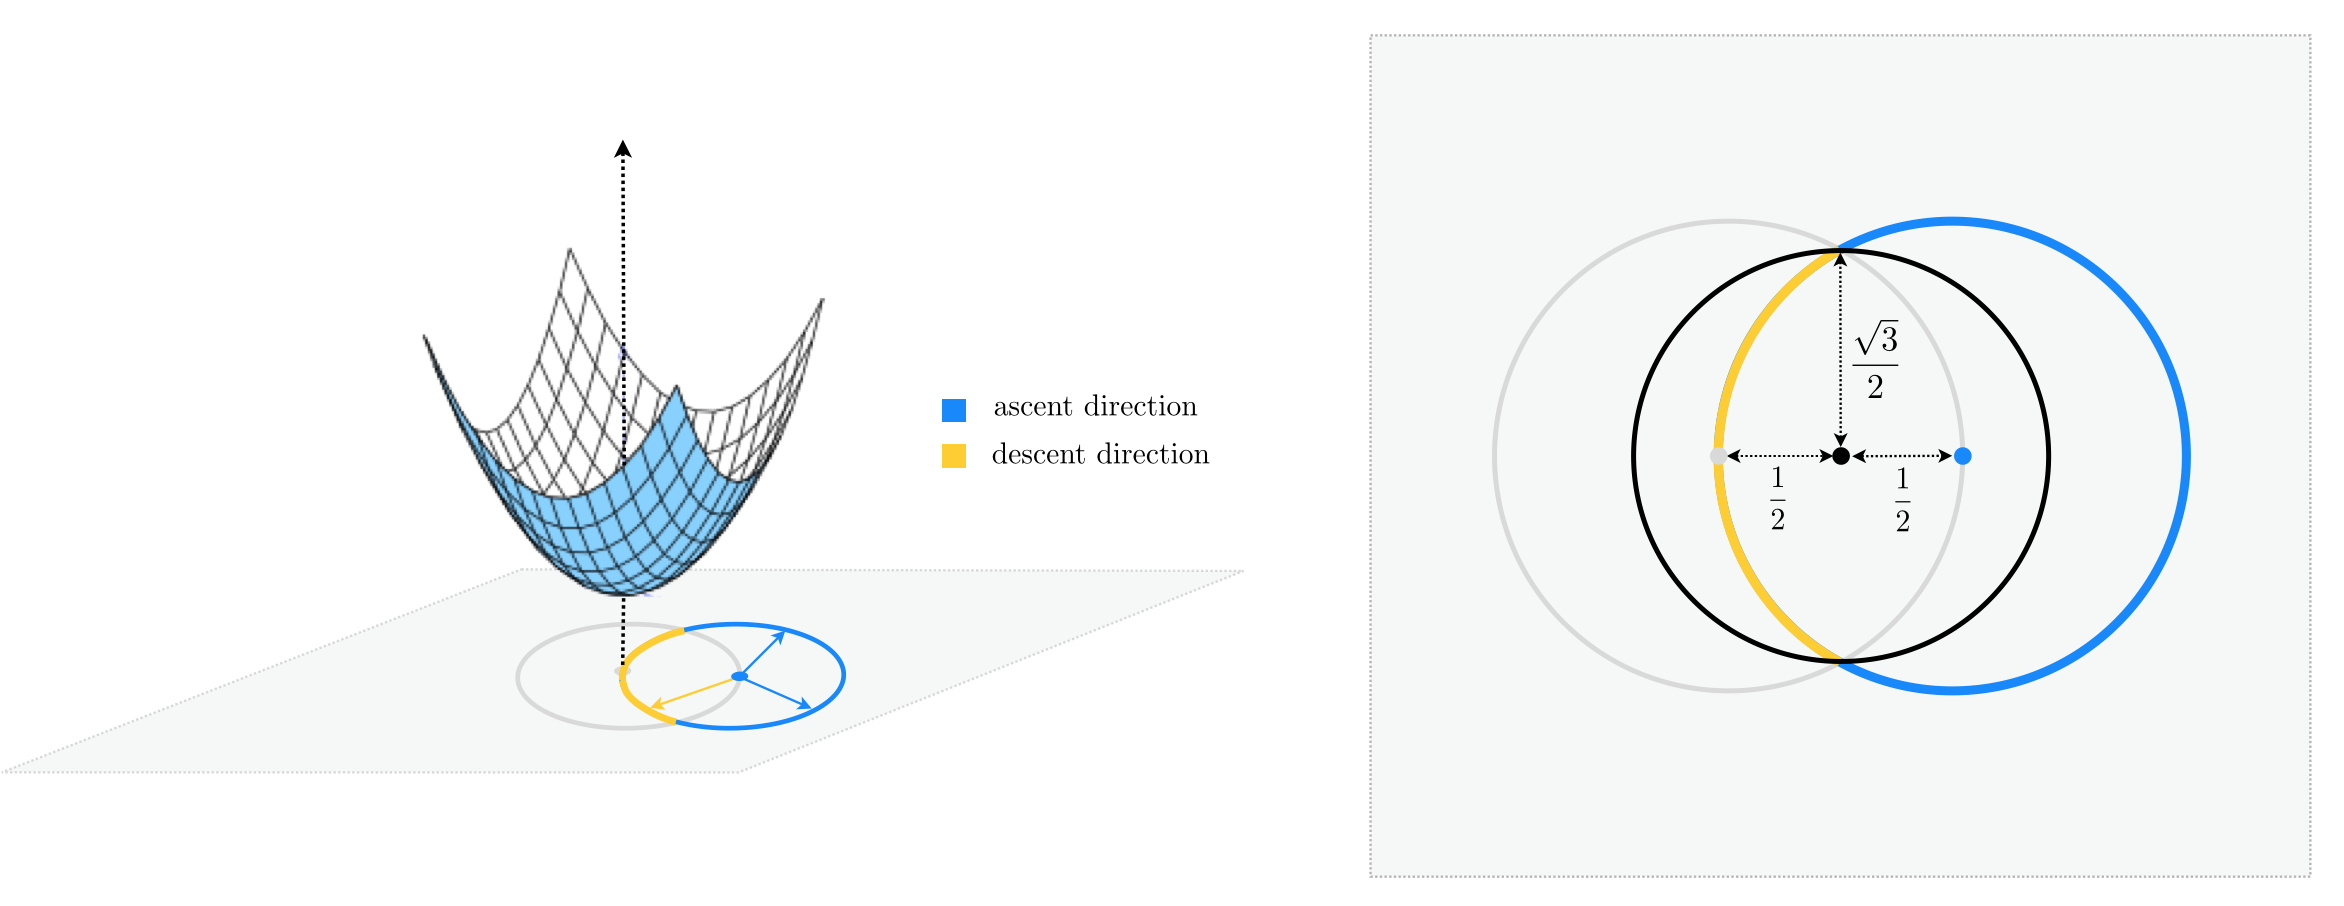

In [13]:
Image(image_path_3, width=1200)

Notice the black circle shown in the right panel, centered at the midpoint of $\mathbf{w}^{0}$ and the origin, completely encompasses the yellow arc, and hence one-half of its length is greater than that of the yellow arc. In other words, the length of the yellow arc is upper-bounded by the length of the black semi-circle that lie inside the unit circle, and we have  

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{\text{length of black circle}}{\text{length of unit circle}}
\end{equation}

Both the numerator and the denominator are now easy to compute, noticing that a simple application of the Pythagorean theorem gives the radius of the black circle as $\frac{\sqrt{3}}{2}$.

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{2\pi\left(\frac{\sqrt{3}}{2}\right)}{2\pi\left(1\right)}=\frac{\sqrt{3}}{4}=0.433
\end{equation}

Therefore in two dimensions, the chance of randomly selecting a descent direction is at most 43%, down 7% from its value in one dimension. 

This rather slight decrease may not seem like a deal breaker at first, but as we travel into larger and larger dimensions we can easily determine that the descent probability shrinks exponentially in $N$. 

This is because in higher dimensions we can still use the same geometric argument we made above to find an upperbound to the descent probability, only this time we are dealing with hyperspheres instead of circles. More specifically, in $N$ we can write  

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{\text{surface area of encompassing hypersphere of radius } \frac{\sqrt{3}}{2}}{\text{surface area of unit hypersphere}}=\frac{1}{2}\cdot\left(\frac{\sqrt{3}}{2}\right)^{N-1}
\end{equation}

So, for instance, when $N=30$ the descent probability falls below 1%. 

## 2.5.4 Summary and conclusions

As we have seen random local search - our first algorithm worthy of coding up - is crippled by the curse of dimensionality, being highly inefficient for even functions with just 30 dimensional input.  Because many modern machine learning cost functions have input dimension $N$  on the order of thousands to hundreds of millions random search itself is not practically useful in the context of most machine learning / deep learning. 

By far the biggest problem with random local search lies in the highly inefficient way in which *descent directions* - that is directions that lead us downward in a function - are found.  If we had a better (i.e., computationally cheaper) way of finding descent directions then the local method paradigm will work extremely well.  This is precisely what we do in the next Section and in particular the next two Chapters, which are dedicated solely to the pursuit of finding good and computationally cheap descent directions for the local paradigm.  There we will show calculus can be leveraged to determine cheap and effective descent directions to power the local method scheme, leading to powerful algorithms called *gradient descent* and *Newton's method*.

## Formalizing the search for the best descent direction*

At the first step of the random local search algorithm we move from our initialization $\mathbf{w}^0$ to a new point $\mathbf{w}^1$, in a unit-length descent direction $\mathbf{d}$ from the initial point.  We decide on this direction by sampling random unit-length directions stemming from $\mathbf{w}^0$.  This gives $P$ random points on the unit hypersphere centered at $\mathbf{w}^0$, i.e., the set of points $\mathbf{w}^0 + \mathbf{d}$ where $\Vert \mathbf{d} \Vert_2 = 1$.  In other words, the first step of our random local search algorithm can be thought of as an imperfect computational approach to finding the smallest value of $g\left(\mathbf{w}^0 + \mathbf{d}^{\,}\right)$ - that is, the very best unit length *descent direction* - over all unit length directions $\mathbf{d}$.  This problem can be stated formally as the constrained optimization problem

\begin{equation}
\begin{array}
\
\underset{\mathbf{d}}{\text{minimize}}\,\,\,g\left(\mathbf{w}^0 + \mathbf{d}^{\,}\right) \\
  \text{subject to} \,\, \Vert \mathbf{d} \Vert_2 = 1
\end{array}
\end{equation}

which is precisely like the optimizations we have looked at so far, only now we are not free to search over every possible $\mathbf{d}$ - only those allowed by the constraint (here those with unit length). Like our original problem this cannot be solve 'by hand' in general.  If we could we would derive the optimal decent step for $g$ at $\mathbf{w}^0$ and there would be no need to perform the random sampling, which again is just our attempt to approximately solve this problem.

Likewise at the $k^{th}$ step of the algorithm, we perform the same sort of random search beginning at the point $\mathbf{w}^{k-1}$ - we are searching for the minimum value of $g$ over the unit hypersphere centered here (the set of points $\mathbf{w}^{k-1} + \mathbf{d}^{\,}$ where $\Vert \mathbf{d} \Vert_2 = 1$).  In other words, we can think of this as an approximation to the solution of the constrained problem

\begin{equation}
\begin{array}
\
\underset{\mathbf{d}}{\text{minimize}}\,\,\,g\left(\mathbf{w}^{k-1} + \mathbf{d}^{\,}\right) \\
  \text{subject to} \,\, \Vert \mathbf{d} \Vert_2 = 1.
\end{array}
\end{equation}

As with the first step, if we could solve the above problem 'by hand' we would not need to randomly sample directions in search of the one providing greatest descent, we could simply solve the problem to recover the best direction for $g$ at $\mathbf{w}^{k-1}$ directly.

Finally notice how we could turn our perspective around with regards to developing the random local search algorithm.  That is we could have *started* with the formal description of the $k^{th}$ step above.  Having determined that the best descent direction could not be determined by solving the above 'by hand' in general, we could have then stumbled onto the $k^{th}$ step of the random local search algorithm as a way of approximately solving it.